In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from MLP_classifier import MultiClassClassifier
from torch.utils.data import DataLoader
import sys
sys.path.append(".")
from dataset import DeepFakeDatasetFastLoad, OOD, DeepFakeTest, RealFakePairs, DoubleCLIP
import torch.nn as nn
import torch
sys.path.append("../tools")
from constants import *
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
sys.path.append("../tools")
from utils import plot_loss_history

# Parameters

In [53]:
device = "cuda:0"
model = MultiClassClassifier(n_classes=len(GEN_TO_INT.keys())).to(device=device)

lr = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

data = DeepFakeDatasetFastLoad(PATH_TO_DATA4 + "df_34000_V2.pt")

rng = torch.Generator().manual_seed(SEED)
train_data, test_data, validation_data = random_split(data,[0.7,0.2,0.1],generator=rng)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data),shuffle=True)
val_loader  = DataLoader(validation_data,batch_size=len(validation_data),shuffle=True)

model.train()

MultiClassClassifier(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
  (act): ReLU()
)

## Train for multi-class classification

In [ ]:
model.set_generators_maps(gen_to_int=GEN_TO_INT,int_to_gen=INT_TO_GEN)

In [ ]:
n_epochs = 1000
val_accuracy = []
loss_history = []
for epoch in range(1,n_epochs+1):
    for idx, batch in enumerate(train_loader):
        # prediction and loss
        pred = model(batch["features"].cuda(device))
        loss = loss_fn(pred,batch["generator"].type(torch.LongTensor).cuda(device))

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    loss, current = loss.item(), idx*batch_size + len(batch["features"])
    if epoch%10 == 0 and epoch > 0:
        loss_history.append(loss)
        for v in val_loader:
            val_accuracy.append(
                model.get_model_accuracy_binary(v["features"],
                                                v["label"],
                                                device))
        print(f"loss: {loss:>7f}  [{epoch:>5d}/{n_epochs:>5d}]")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.set_title("loss")
ax2.set_title("accuracy on validation")
ax1.plot(range(1,n_epochs+1,10),loss_history)
ax2.plot(range(1,n_epochs+1,10),val_accuracy)
ax1.grid()
ax2.grid() 
plt.show()

## Test for binary classification

In [ ]:
import torch.types

with torch.no_grad():
    model.eval()
    for e in test_loader:
        accuracy = model.get_model_accuracy_binary(features=e["features"],
                                                   true_labels=e["label"],
                                                   device=device)
print(accuracy)

### Comparison with SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(dual="auto"))

In [ ]:
train_loader_all = DataLoader(train_data,batch_size=len(train_data))
for e in train_loader_all:
    X_train = e["features"]
    gen_train = e["generator"]
    label_train = e["label"]
for e in test_loader:
    X_test = e["features"]
    gen_test = e["generator"]
    label_test = e["label"]

clf.fit(X_train, gen_train) # train on multi-class classification

In [ ]:
import numpy as np
pred = data.class_to_label(clf.predict(X_test))
np.mean(label_test.numpy() == pred.numpy()) # binary classification performance

## Test on multi-class classification

### Neural Network

In [ ]:
import torch.types

with torch.no_grad():
    model.eval()
    for e in test_loader:
        accuracy = model.get_model_accuracy_multiclass(features=e["features"],
                                            true_classes=e["generator"],
                                            device="cuda:"+str(device))
print(accuracy)

### SVM

In [ ]:
clf.fit(X_train,gen_train).score(X_test,gen_test)

# Saving the model

In [57]:
path = f"./checkpoints/multiclass_epochs=1000_loss=0.0692238137125969.pt"
# torch.save(model.state_dict(),path)

# Loading the model

In [58]:
model = MultiClassClassifier(n_classes=len(GEN_TO_INT.keys()))
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [60]:
model.eval().cuda(device)
with torch.no_grad():
    for e in test_loader:
        pred = torch.argmax(model(e["features"].cuda(device)),dim=1)
        acc = torch.mean(torch.eq(e["generator"].cuda(device),pred).float()).item()
        print(acc)

0.9085294008255005


# Train on data3 test on SB

In [ ]:
from utils import load_synthbuster_balanced
X_sb, y_sb = load_synthbuster_balanced(PATH_TO_DATA4 + "synthbuster_test",
                                       binary_classification=True,
                                       balance_real_fake=True)

In [ ]:
model.get_model_accuracy_binary(torch.Tensor(X_sb).cuda(device),
                                torch.Tensor(y_sb).cuda(device),
                                device)

# Test on OOD

In [ ]:
ood = OOD("../../data/ood",load_preprocessed=False,device="cuda:" + str(device))

In [ ]:
# ood.save("../../data/ood.pt")

In [ ]:
ood2 = OOD(PATH_TO_DATA4 + "ood.pt",load_preprocessed=True)

In [ ]:
loader_test = DataLoader(ood2, batch_size=len(ood2), shuffle=True)

In [ ]:
for e in loader_test:
    model.eval()
    with torch.no_grad():
        accuracy = model.get_model_accuracy_binary(e["features"],e["label"],device)

print(accuracy)

# Training a binary classifier

In [67]:
device = "cuda:0"
clf_binary = MultiClassClassifier(n_classes=2).to(device)

lr = 1e-3
batch_size = 128
n_epochs = 1000

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_binary.parameters(), lr=lr)

data = DeepFakeDatasetFastLoad(PATH_TO_DATA4 + "df_34000_V2.pt",
                               remove_blacklisted_gen=True)
clf_binary.set_generators_maps(gen_to_int=GEN_TO_INT,int_to_gen=INT_TO_GEN)


rng = torch.Generator().manual_seed(SEED)
train_data, test_data, validation_data = random_split(data,[0.7,0.2,0.1],generator=rng)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data),shuffle=True)
val_loader  = DataLoader(validation_data,batch_size=len(validation_data),shuffle=True)

clf_binary.train()

filtering:   0%|          | 0/12 [00:00<?, ?it/s]

filtering: 100%|██████████| 12/12 [00:00<00:00, 158.71it/s]


MultiClassClassifier(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (act): ReLU()
)

In [68]:
val_accuracy = []
loss_history = []
for epoch in range(1,n_epochs+1):
    for idx, batch in enumerate(train_loader):
        # prediction and loss
        pred = clf_binary(batch["features"].to(device))
        loss = loss_fn(pred,batch["label"].type(torch.LongTensor).to(device))

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    loss, current = loss.item(), idx*batch_size + len(batch["features"])
    if epoch%10 == 0 and epoch > 0:
        loss_history.append(loss)
        for v in val_loader:
            pred = torch.argmax(clf_binary(v["features"].to(device)),dim=1)
            val_accuracy.append(torch.mean(torch.eq(v["label"].to(device),pred).float()).item())
        print(f"loss: {loss:>7f}  [{epoch:>5d}/{n_epochs:>5d}]")

loss: 0.254174  [   10/ 1000]
loss: 0.093920  [   20/ 1000]
loss: 0.450883  [   30/ 1000]
loss: 0.014565  [   40/ 1000]
loss: 0.043445  [   50/ 1000]
loss: 0.054383  [   60/ 1000]
loss: 0.012452  [   70/ 1000]
loss: 0.104798  [   80/ 1000]
loss: 0.033186  [   90/ 1000]
loss: 0.009909  [  100/ 1000]
loss: 0.024631  [  110/ 1000]
loss: 0.030945  [  120/ 1000]
loss: 0.050639  [  130/ 1000]
loss: 0.002710  [  140/ 1000]
loss: 0.011735  [  150/ 1000]
loss: 0.124056  [  160/ 1000]
loss: 0.031568  [  170/ 1000]
loss: 0.021027  [  180/ 1000]
loss: 0.003857  [  190/ 1000]
loss: 0.053024  [  200/ 1000]
loss: 0.060919  [  210/ 1000]
loss: 0.016649  [  220/ 1000]
loss: 0.035134  [  230/ 1000]
loss: 0.005480  [  240/ 1000]
loss: 0.008170  [  250/ 1000]
loss: 0.009000  [  260/ 1000]
loss: 0.020427  [  270/ 1000]
loss: 0.160656  [  280/ 1000]
loss: 0.045226  [  290/ 1000]
loss: 0.044380  [  300/ 1000]
loss: 0.007756  [  310/ 1000]
loss: 0.001458  [  320/ 1000]
loss: 0.006739  [  330/ 1000]
loss: 0.02

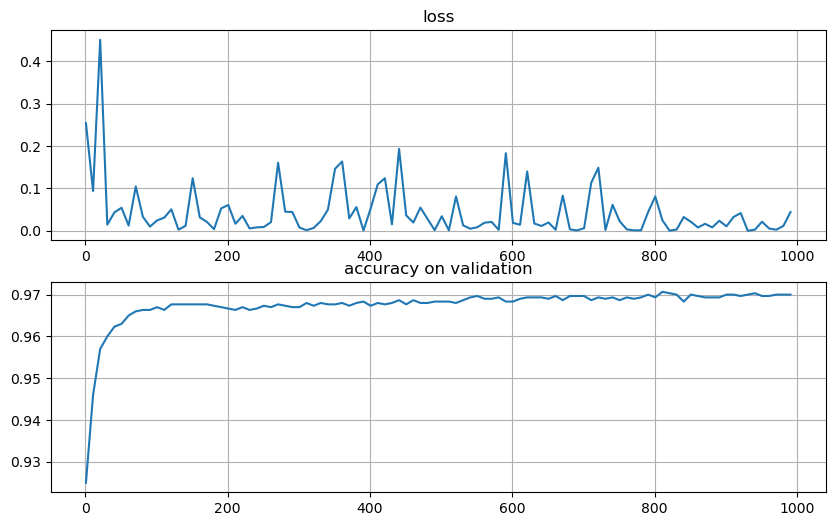

In [69]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.set_title("loss")
ax2.set_title("accuracy on validation")
ax1.plot(range(1,n_epochs+1,10),loss_history)
ax2.plot(range(1,n_epochs+1,10),val_accuracy)
ax1.grid()
ax2.grid() 
plt.show()

In [70]:
# path = f"./checkpoints/binary_epochs={n_epochs}_loss={loss}_filtered.pt"
torch.save(clf_binary.state_dict(),path)

## Binary classifier Test VS MultiClass classifier

In [6]:
clf_binary.load_state_dict(torch.load("./checkpoints/binary_epochs=1000_loss=0.02289319783449173.pt"))
clf_binary.eval()

<All keys matched successfully>

In [16]:
model = MultiClassClassifier(n_classes=len(GEN_TO_INT.keys()))
model.eval()
model.load_state_dict(torch.load("./checkpoints/multiclass_epochs=1000_loss=0.0692238137125969.pt"))
model.set_generators_maps(GEN_TO_INT,INT_TO_GEN)

In [17]:
for e in test_loader:
    with torch.no_grad():
        print("Accuracy with binary classifier:     ",clf_binary.get_model_accuracy_binary(e["features"],e["label"],device,binary_model=True))
        print("Accuracy with multi-class classifier:",model.get_model_accuracy_binary(e["features"],e["label"],"cpu",binary_model=False))

Accuracy with binary classifier:      0.9754411578178406
Accuracy with multi-class classifier: 0.9752941131591797


## Test on AID_TEST

In [73]:
data_test = DeepFakeTest(PATH_TO_DATA4 + "df_test_60000.pt",
                         load_from_disk=True,
                         remove_blacklisted_gen=True)

with torch.no_grad():
    
    print("Accuracy with binary classifier:     ",
          clf_binary.get_model_accuracy_binary(data_test.features,
                                               data_test.label,
                                               device,
                                               binary_model=True))
    model.set_generators_maps(gen_to_int=GEN_TO_INT,int_to_gen=INT_TO_GEN)
    print("Accuracy with multi-class classifier:",
          model.get_model_accuracy_binary(data_test.features.to(device),
                                          data_test.label.to(device),
                                          device,
                                          binary_model=False))

filtering: 100%|██████████| 3/3 [00:00<00:00, 2833.99it/s]

Accuracy with binary classifier:      0.7097500562667847
Accuracy with multi-class classifier: 0.7320000529289246


# Accuracy per class

In [74]:
d_AID = {}
d_AID_TEST = {}

for e in test_loader:
    features = e["features"]
    label    = e["label"]
    gen      = e["generator"]

for key in GEN_TO_GEN:
    d_AID[key] = {
        "features": features[gen == GEN_TO_INT[key]],
        "label": label[gen == GEN_TO_INT[key]]
    }
    d_AID_TEST[key] = {
        "features": data_test.features[data_test.gen == GEN_TO_INT[key]],
        "label"   : data_test.label[data_test.gen == GEN_TO_INT[key]]}

In [77]:
torch.bincount(data.gen)

tensor([17000,  3000,  2000,  1000,  1000,  1000,  1000,  1000,  1000,  1000,
         1000,  1000,  2000,     0,     0,  1000])

In [79]:
torch.bincount(data_test.gen.int())

tensor([30000,  6000,  3000,  2000,  2000,  1000,  1000,  1000,  1000,  1000,
         1000,  3000,  4000,  1000,  1000,  2000], device='cuda:0')

In [81]:
accuracy_AID = {"binary":{},"multi":{}} # accuracy on the test data from the same folder as training data
accuracy_AID_TEST = {"binary":{},"multi":{}} # accuracy on data from AID_TEST (can be seen as OOD)
for g in d_AID:
    with torch.no_grad():
        accuracy_AID["binary"][g] = \
            model.get_model_accuracy_binary(d_AID[g]["features"],
                                            d_AID[g]["label"],
                                            "cpu",
                                            binary_model=False)
        
        accuracy_AID["multi"][g] = \
            model.get_model_accuracy_multiclass(
                d_AID[g]["features"],
                torch.ones_like(d_AID[g]["label"]) * GEN_TO_INT[g],
                "cpu")

        accuracy_AID_TEST["binary"][g] = \
            model.get_model_accuracy_binary(d_AID_TEST[g]["features"],
                                            d_AID_TEST[g]["label"],
                                            "cpu",
                                            binary_model=False)
        
        accuracy_AID_TEST["multi"][g] = \
            model.get_model_accuracy_multiclass(
                d_AID_TEST[g]["features"],
                torch.ones_like(d_AID_TEST[g]["label"]) * GEN_TO_INT[g],
                "cpu")

display("binary accuracy on test from AID:",accuracy_AID["binary"])
display("binary accuracy on AID_TEST:     ",accuracy_AID_TEST["binary"])
display("multi-class accuracy on test from AID:",accuracy_AID["multi"])        
display("multi-class accuracy on AID_TEST:",accuracy_AID_TEST["multi"])        

'binary accuracy on test from AID:'

{'null': 0.9822364449501038,
 'Stable diffusion': 0.9640522599220276,
 'Kandisky': 0.9897435903549194,
 'DF_XL': 0.9519230723381042,
 'dreamlike': 0.9402984976768494,
 'gigaGan': 0.8612716794013977,
 'GlideUP': 0.9902912378311157,
 'LafitteUP': 0.9952830076217651,
 'LCM_Dreamshaper': 0.994535505771637,
 'megaDallEUP': 0.9892473220825195,
 'miniDallEUP': 0.9948186278343201,
 'pixart': 0.9947368502616882,
 'playground': 0.9410377144813538,
 'styleGan2': nan,
 'styleGan3': nan,
 'animagineXL': 0.9893617033958435}

'binary accuracy on AID_TEST:     '

{'null': 0.562666654586792,
 'Stable diffusion': 0.9446666836738586,
 'Kandisky': 0.8793333172798157,
 'DF_XL': 0.8870000243186951,
 'dreamlike': 0.7275000214576721,
 'gigaGan': 0.8100000023841858,
 'GlideUP': 0.9940000176429749,
 'LafitteUP': 0.9980000257492065,
 'LCM_Dreamshaper': 0.9800000190734863,
 'megaDallEUP': 0.9909999966621399,
 'miniDallEUP': 0.9929999709129333,
 'pixart': 0.890666663646698,
 'playground': 0.8812500238418579,
 'styleGan2': 0.7480000257492065,
 'styleGan3': 0.6819999814033508,
 'animagineXL': 0.9884999990463257}

'multi-class accuracy on test from AID:'

{'null': 0.9822364449501038,
 'Stable diffusion': 0.8235294222831726,
 'Kandisky': 0.8487179279327393,
 'DF_XL': 0.870192289352417,
 'dreamlike': 0.6368159055709839,
 'gigaGan': 0.7398843765258789,
 'GlideUP': 0.9368932247161865,
 'LafitteUP': 0.9905660152435303,
 'LCM_Dreamshaper': 0.9234972596168518,
 'megaDallEUP': 0.8655914068222046,
 'miniDallEUP': 0.9430052042007446,
 'pixart': 0.699999988079071,
 'playground': 0.7429245114326477,
 'styleGan2': nan,
 'styleGan3': nan,
 'animagineXL': 0.9042553305625916}

'multi-class accuracy on AID_TEST:'

{'null': 0.562666654586792,
 'Stable diffusion': 0.6356666684150696,
 'Kandisky': 0.6086666584014893,
 'DF_XL': 0.07699999958276749,
 'dreamlike': 0.09099999815225601,
 'gigaGan': 0.2809999883174896,
 'GlideUP': 0.9430000185966492,
 'LafitteUP': 0.9950000047683716,
 'LCM_Dreamshaper': 0.8920000195503235,
 'megaDallEUP': 0.9100000262260437,
 'miniDallEUP': 0.9169999957084656,
 'pixart': 0.07599999755620956,
 'playground': 0.10724999755620956,
 'styleGan2': 0.0,
 'styleGan3': 0.0,
 'animagineXL': 0.4230000078678131}

# Binary classifier

### Performance of binary classifier on pair dataset

In [74]:
device = "cuda:0"

model = MultiClassClassifier(n_classes=2).to(device=device)
model.eval()
model.load_state_dict(torch.load("./checkpoints/binary_epochs=1000_loss=0.04426886886358261_filtered.pt"))

lr = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

data = RealFakePairs(load_from_disk=True,path="/data4/saland/data/real_fake_pairs_1090.pt",device="cuda:0")

with torch.no_grad():
    acc = model.get_model_accuracy_binary(features=data.features,
                                           true_labels=data.label,
                                           device=device,
                                           binary_model=True)
print(acc)

0.899082601070404


### Train on 800 pairs and test on 200

In [205]:
device = "cuda:1"
model = MultiClassClassifier(n_classes=2,n_features=CLIP_FEATURE_DIM).to(device=device)
model_double = MultiClassClassifier(n_classes=2,n_features=CLIP_FEATURE_DIM*2).to(device=device)
model_diff = MultiClassClassifier(n_classes=2,n_features=CLIP_FEATURE_DIM).to(device=device)
model.train()
model_double.train()
model_diff.train()
# model.load_state_dict(torch.load("./checkpoints/binary_epochs=1000_loss=0.02289319783449173.pt"))

lr = 1e-3
batch_size = 64
n_epochs = 1000

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer2 = torch.optim.SGD(model_double.parameters(), lr=lr)
optimizer3 = torch.optim.SGD(model_diff.parameters(), lr=lr)

rng = torch.Generator().manual_seed(SEED)

data = DoubleCLIP(load_from_disk=True,path_to_datset="/data4/saland/data/Double_CLIP_2000.pt")
train_data, test_data = random_split(data,[0.2,0.8],generator=rng)

train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=len(test_data))

In [181]:
loss_history = []
for epoch in range(1,n_epochs+1):
    for idx, batch in enumerate(train_loader):
        # prediction and loss
        pred = model(batch["features"][:,:CLIP_FEATURE_DIM].to(device))
        loss = loss_fn(pred,batch["label"].type(torch.LongTensor).to(device))

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    loss, current = loss.item(), idx*batch_size + len(batch["features"])
    if epoch%10 == 0 and epoch > 0:
        loss_history.append(loss)
        print(f"loss: {loss:>7f}  [{epoch:>5d}/{n_epochs:>5d}]")

loss: 0.583756  [   10/ 1000]
loss: 0.539579  [   20/ 1000]
loss: 0.438721  [   30/ 1000]
loss: 0.416519  [   40/ 1000]
loss: 0.408712  [   50/ 1000]
loss: 0.309370  [   60/ 1000]
loss: 0.267908  [   70/ 1000]
loss: 0.294130  [   80/ 1000]
loss: 0.225140  [   90/ 1000]
loss: 0.182545  [  100/ 1000]
loss: 0.256157  [  110/ 1000]
loss: 0.158156  [  120/ 1000]
loss: 0.207466  [  130/ 1000]
loss: 0.209256  [  140/ 1000]
loss: 0.140768  [  150/ 1000]
loss: 0.068818  [  160/ 1000]
loss: 0.142247  [  170/ 1000]
loss: 0.119114  [  180/ 1000]
loss: 0.068986  [  190/ 1000]
loss: 0.068263  [  200/ 1000]
loss: 0.112906  [  210/ 1000]
loss: 0.071339  [  220/ 1000]
loss: 0.076113  [  230/ 1000]
loss: 0.060360  [  240/ 1000]
loss: 0.039138  [  250/ 1000]
loss: 0.081971  [  260/ 1000]
loss: 0.039457  [  270/ 1000]
loss: 0.039661  [  280/ 1000]
loss: 0.092106  [  290/ 1000]
loss: 0.042148  [  300/ 1000]
loss: 0.029439  [  310/ 1000]
loss: 0.053061  [  320/ 1000]
loss: 0.054157  [  330/ 1000]
loss: 0.07

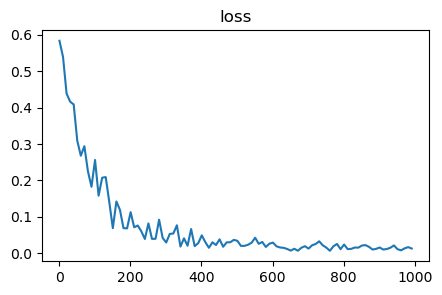

In [182]:
fig= plt.figure(figsize=(5,3))
plt.title("loss")
plt.plot(range(1,n_epochs+1,10),loss_history) 
plt.show()

In [183]:
model.eval()
with torch.no_grad():
    for e in test_loader:
        print("n_train:",len(train_data))
        print("n_test:",len(test_data))
        acc = model.get_model_accuracy_binary(e["features"][:,:CLIP_FEATURE_DIM],e["label"],device,True)

print(acc)
accuracy_768_features = acc

n_train: 400
n_test: 1600
0.9906249642372131


### Train on concatenated version of CLIP features

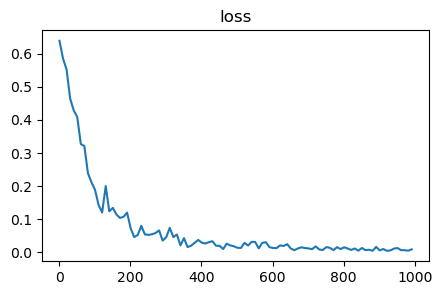

In [185]:
fig= plt.figure(figsize=(5,3))
plt.title("loss")
plt.plot(range(1,n_epochs+1,10),loss_history) 
plt.show()

In [186]:
model.eval()
with torch.no_grad():
    for e in test_loader:
        acc = model_double.get_model_accuracy_binary(e["features"],e["label"],device,True)

print("n_train:",len(train_data))
print("n_test:",len(test_data))
print("Accuracy 768 CLIP features:   ",accuracy_768_features)
print("Accuracy double CLIP features:",acc)

n_train: 400
n_test: 1600
Accuracy 768 CLIP features:    0.9906249642372131
Accuracy double CLIP features: 0.9899999499320984


Looking at the weights associated to each CLIP features (original and generated image)

In [194]:
torch.sum(torch.abs(model_double.fc1.weight[:768])).item()

10058.380859375

In [200]:
torch.sum(torch.abs(model_double.fc1.weight[:,768:])).item()

5020.86669921875

### Train on the difference between the 2 CLIP vectors

In [ ]:
loss_history = []
for epoch in range(1,n_epochs+1):
    for idx, batch in enumerate(train_loader):
        # prediction and loss
        pred = model_diff((batch["features"][:,:CLIP_FEATURE_DIM] - batch["features"][:,CLIP_FEATURE_DIM:]).to(device))
        loss = loss_fn(pred,batch["label"].type(torch.LongTensor).to(device))

        # backpropagation
        loss.backward()
        optimizer3.step()
        optimizer3.zero_grad()
        
    loss, current = loss.item(), idx*batch_size + len(batch["features"])
    if epoch%10 == 0 and epoch > 0:
        loss_history.append(loss)
        print(f"loss: {loss:>7f}  [{epoch:>5d}/{n_epochs:>5d}]")

In [207]:
model.eval()
with torch.no_grad():
    for e in test_loader:
        acc_diff = model_diff.get_model_accuracy_binary((e["features"][:,:CLIP_FEATURE_DIM] - e["features"][:,CLIP_FEATURE_DIM:]),e["label"],device,True)

print("n_train:",len(train_data))
print("n_test:",len(test_data))
print("Accuracy 768 CLIP features:       ",accuracy_768_features)
print("Accuracy double CLIP features:    ",acc)
print("Accuracy difference CLIP features:",acc_diff)

n_train: 400
n_test: 1600
Accuracy 768 CLIP features:        0.9906249642372131
Accuracy double CLIP features:     0.9899999499320984
Accuracy difference CLIP features: 0.9300000071525574


## Test on OOD of model trained on AID and fine-tuned on real/fake pairs

In [83]:
device = "cuda:1"
model = MultiClassClassifier(n_classes=2).to(device)
model.load_state_dict(torch.load("checkpoints/binary_epochs=1000_loss=0.04426886886358261_filtered.pt"))
model.eval()

MultiClassClassifier(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (act): ReLU()
)

In [84]:
data_test = OOD("/data4/saland/data/ood.pt",load_preprocessed=True)

acc = model.get_model_accuracy_binary(data_test.features,data_test.label,device,binary_model=True)
print("accuracy of model on OOD before fine-tuning on real/fake pairs:",acc)

accuracy of model on OOD before fine-tuning on real/fake pairs: 0.574999988079071


### Fine-tuning on real/fake pairs

In [86]:
lr = 1e-3
batch_size = 64
n_epochs = 1000

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

model.train()
rng = torch.Generator().manual_seed(SEED)
data = RealFakePairs(load_from_disk=True,path="/data4/saland/data/real_fake_pairs_1090.pt")
train_loader = DataLoader(data,batch_size=batch_size,shuffle=True,generator=rng)

In [87]:
loss_history = []
for epoch in range(1,n_epochs+1):
    for idx, batch in enumerate(train_loader):
        # prediction and loss
        pred = model((batch["features"]).to(device))
        loss = loss_fn(pred,batch["label"].type(torch.LongTensor).to(device))

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    loss, current = loss.item(), idx*batch_size + len(batch["features"])
    if epoch%10 == 0 and epoch > 0:
        loss_history.append(loss)
        print(f"loss: {loss:>7f}  [{epoch:>5d}/{n_epochs:>5d}]")

loss: 0.015049  [   10/ 1000]
loss: 0.000966  [   20/ 1000]
loss: 0.000168  [   30/ 1000]
loss: 0.002442  [   40/ 1000]
loss: 0.053081  [   50/ 1000]
loss: 0.005211  [   60/ 1000]
loss: 0.086782  [   70/ 1000]
loss: 0.010773  [   80/ 1000]
loss: 0.011378  [   90/ 1000]
loss: 0.074592  [  100/ 1000]
loss: 0.094963  [  110/ 1000]
loss: 0.000023  [  120/ 1000]
loss: 0.012108  [  130/ 1000]
loss: 0.000019  [  140/ 1000]
loss: 0.000204  [  150/ 1000]
loss: 0.002144  [  160/ 1000]
loss: 0.044645  [  170/ 1000]
loss: 0.007386  [  180/ 1000]
loss: 0.146403  [  190/ 1000]
loss: 0.000056  [  200/ 1000]
loss: 0.000601  [  210/ 1000]
loss: 0.009709  [  220/ 1000]
loss: 0.000425  [  230/ 1000]
loss: 0.000116  [  240/ 1000]
loss: 0.002971  [  250/ 1000]
loss: 0.002528  [  260/ 1000]
loss: 0.000010  [  270/ 1000]
loss: 0.000007  [  280/ 1000]
loss: 0.000004  [  290/ 1000]
loss: 0.000049  [  300/ 1000]
loss: 0.005074  [  310/ 1000]
loss: 0.000014  [  320/ 1000]
loss: 0.000102  [  330/ 1000]
loss: 0.00

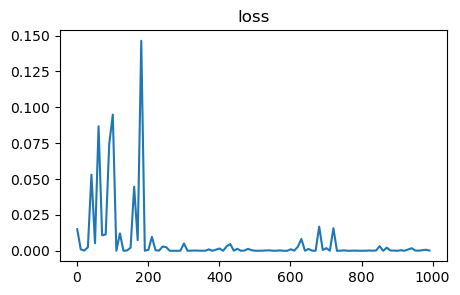

In [88]:
plot_loss_history(loss_history=loss_history,n_epochs=n_epochs,title="loss")

In [89]:
acc = model.get_model_accuracy_binary(data_test.features,data_test.label,device,True)
print("accuracy of the model on OOD after fine-tuning:",acc)

accuracy of the model on OOD after fine-tuning: 0.5237500071525574
